<a href="https://colab.research.google.com/github/daspartho/fastai-part2/blob/main/img2img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
import torch
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from PIL import Image
from IPython import display
import logging
from pathlib import Path
from huggingface_hub import notebook_login

In [3]:
logging.disable(logging.WARNING)
if not (Path.home()/'.huggingface'/'token').exists(): 
    notebook_login()

In [4]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
).to("cuda")

vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "vae",
    torch_dtype = torch.float16,
).to("cuda")

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "unet",
    torch_dtype = torch.float16,
).to("cuda")

beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)

In [5]:
def prep_text(prompt):

    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_embedding = text_encoder(
        text_input.input_ids.to("cuda")
    )[0].half()

    uncond_input = tokenizer(
        [""],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    uncond_embedding = text_encoder(
        uncond_input.input_ids.to("cuda")
    )[0].half()

    return torch.cat([uncond_embedding, text_embedding])

In [6]:
def encode(img):
    with torch.no_grad():
        latent = vae.encode(
            tfms.ToTensor()(img).unsqueeze(0).to("cuda").half()
            )
        latent = 0.18215 * latent.latent_dist.sample()
    return latent

In [7]:
def decode(latent):
    with torch.no_grad():
        img = vae.decode(1 / 0.18215 * latent).sample

    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).numpy()
    img = (img * 255).round().astype("uint8")
    return Image.fromarray(img[0])

In [8]:
def Img2Img(
    prompt,
    img_path, 
    steps=50,
    guidance_scale=7.5, 
    start_step=10,
    seed=32,
    height=512,
    width=512,
    ):

    prompt = [prompt]
    text_embeddings = prep_text(prompt)

    scheduler.set_timesteps(steps)

    img = Image.open(img_path).resize((height, width))
    encoded = encode(img)

    torch.manual_seed(seed)
    noise = torch.randn(
        (1,unet.in_channels,height // 8,width // 8),
    ).to("cuda").half()

    latents = scheduler.add_noise(
        encoded, 
        noise, 
        timesteps=torch.tensor([scheduler.timesteps[start_step]])
    )

    for i, t in enumerate(tqdm(scheduler.timesteps)):
        if i > start_step:
            input = torch.cat([latents]*2)
            input = scheduler.scale_model_input(input, t)

            with torch.no_grad():
                pred = unet(
                    input, 
                    t,
                    encoder_hidden_states=text_embeddings,
                ).sample

            pred_uncond, pred_text = pred.chunk(2)
            pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

            latents = scheduler.step(pred, t, latents).prev_sample

    image = decode(latents)
    display.display(image)

In [9]:
!curl --output test.jpg 'https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.universetoday.com%2Fwp-content%2Fuploads%2F2013%2F10%2Fapollo_11.jpg&f=1&nofb=1&ipt=55158bb2224110be1eaa11a0b620401067068d4526a8373781a8e2655797cd40&ipo=images'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2067k    0 2067k    0     0  7952k      0 --:--:-- --:--:-- --:--:-- 7952k


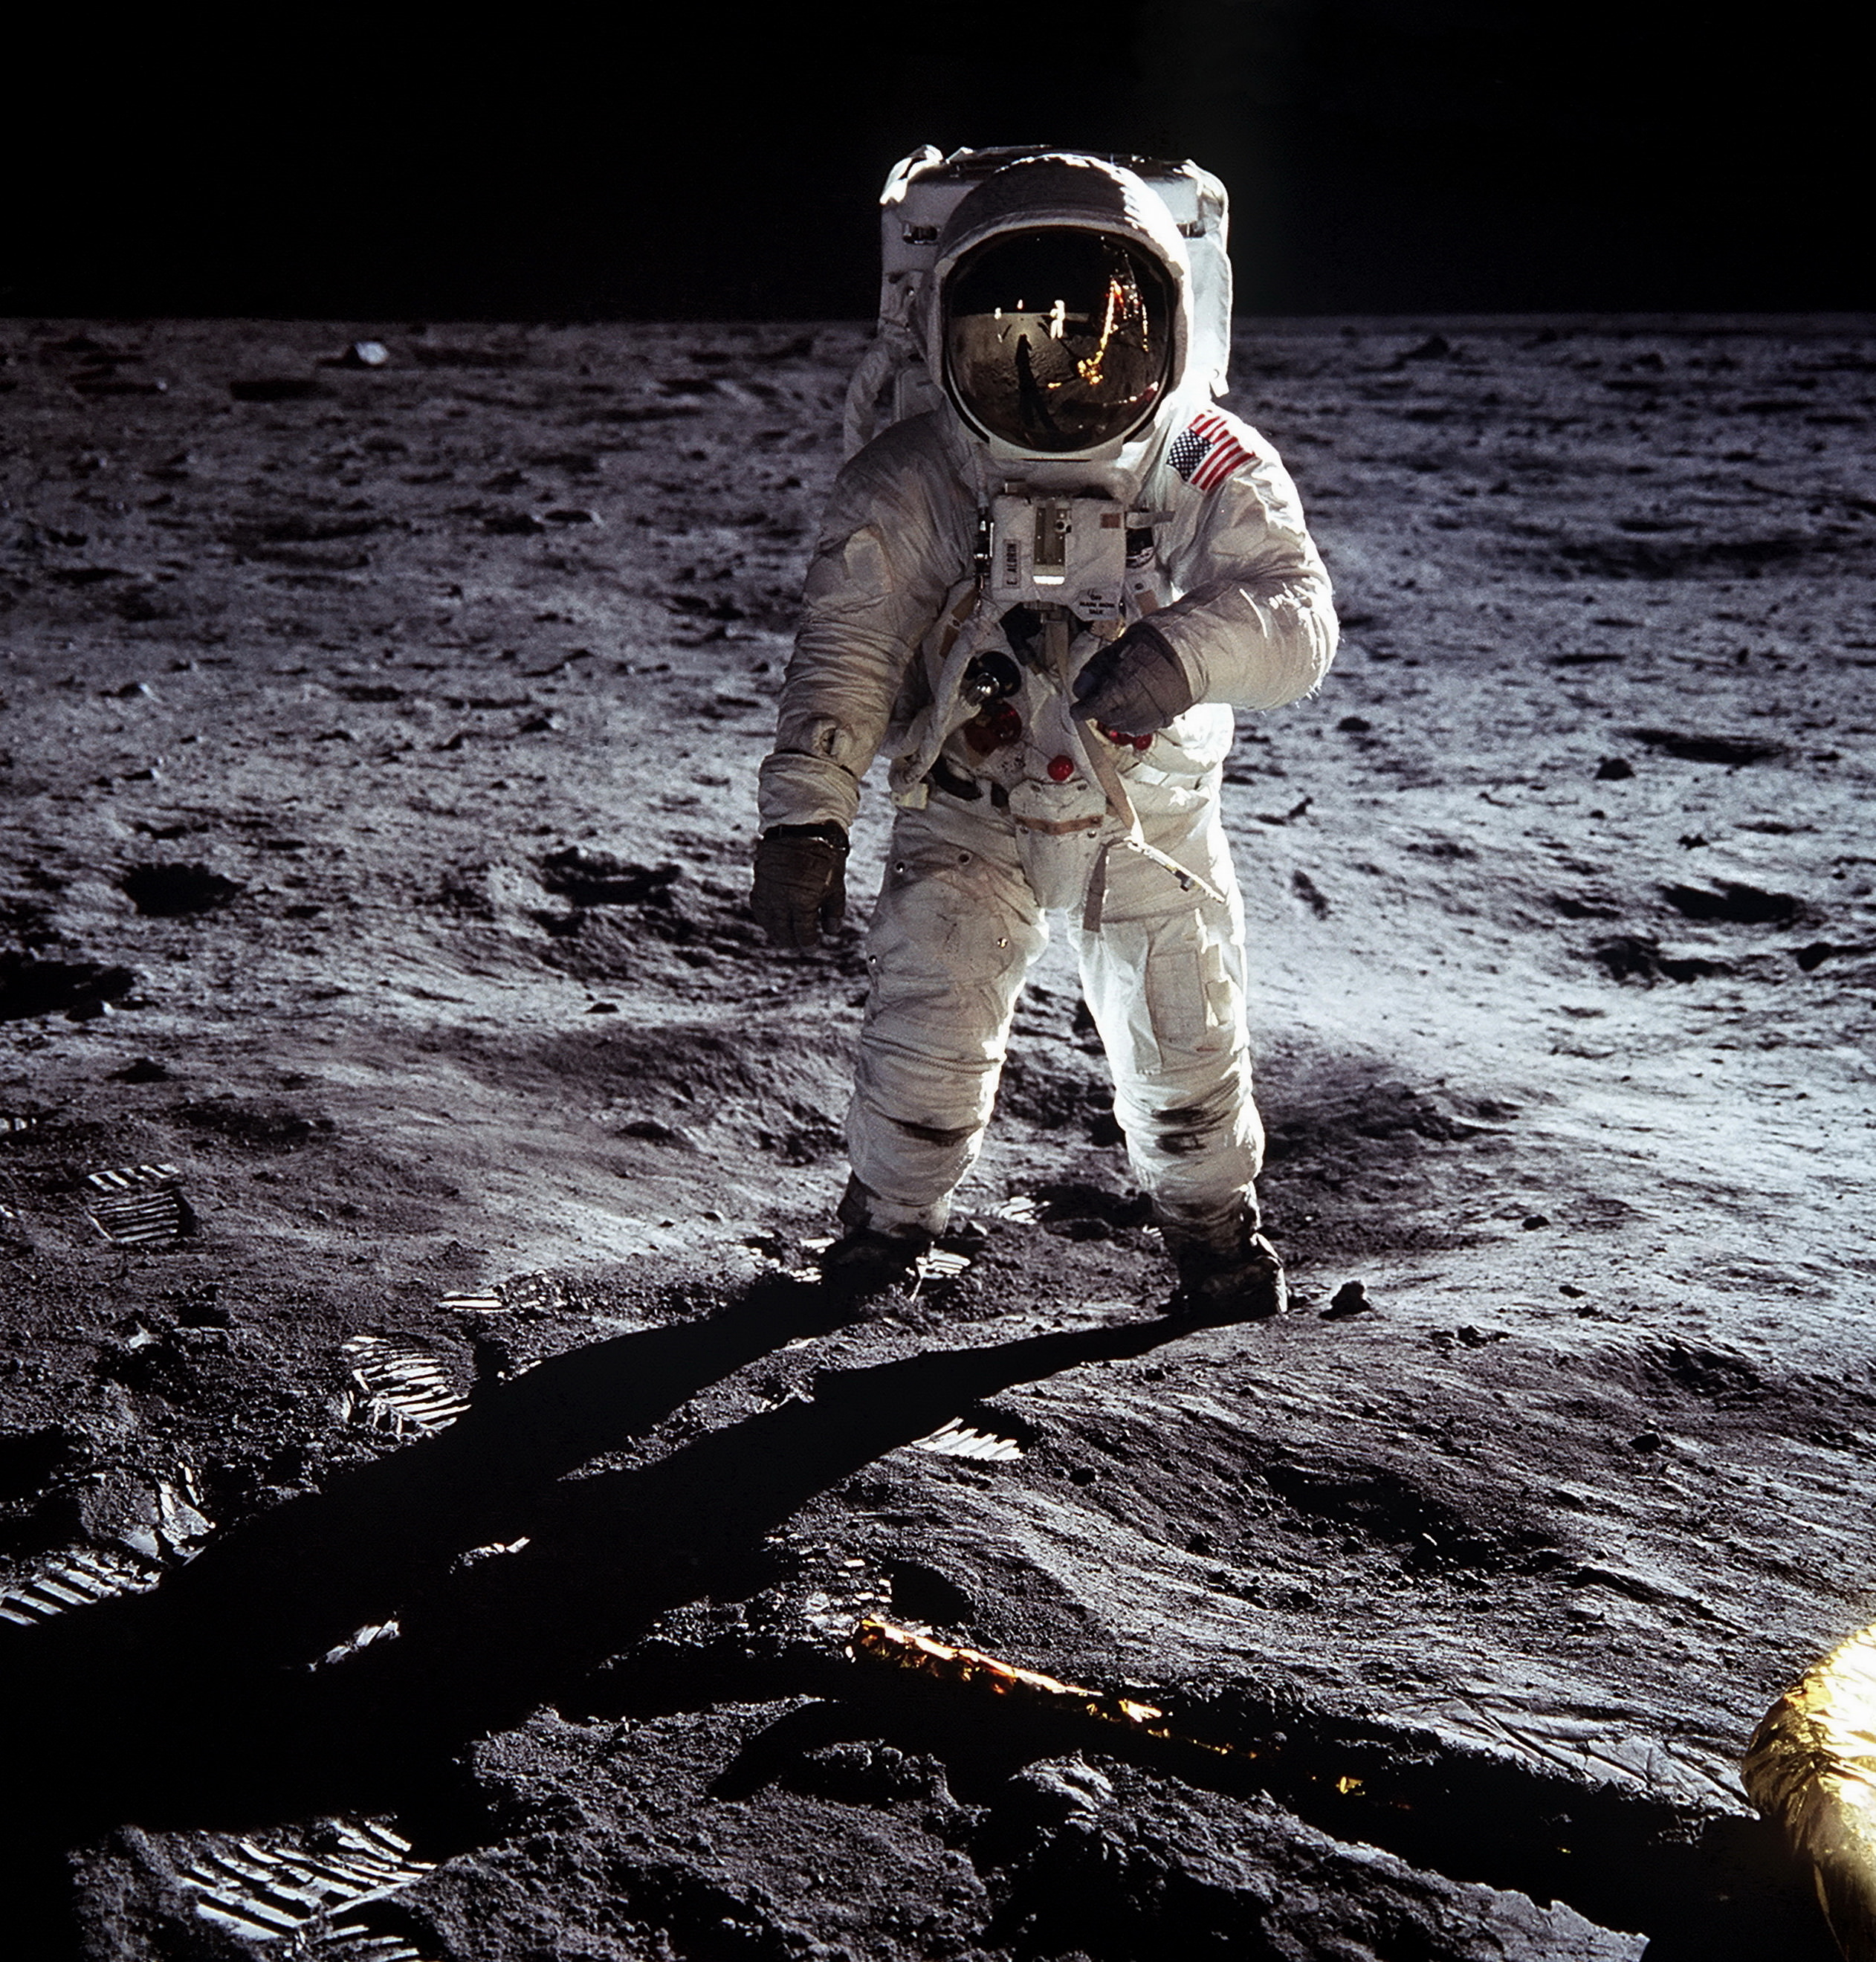

In [10]:
display.Image(filename='test.jpg') 

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:146: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrated_coeff = integrate.quad(lms_derivative, self.sigmas[t], self.sigmas[t + 1], epsrel=1e-4)[0]


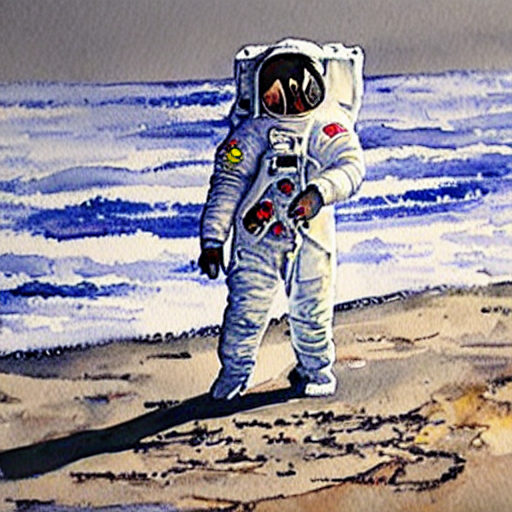

In [11]:
Img2Img(
    "A watercolor painting of an astronaut on a beach",
    "test.jpg",
    steps=50,
    guidance_scale=7.5, 
    start_step=10,
    seed=32,
    height=512,
    width=512,
)